In [31]:
import numpy as np
from math import pi, tan, cos, exp, sin
from scipy.optimize import fsolve
from decimal import Decimal
import pandas as pd
import matplotlib.pyplot as plt
# from progress.bar import FillingCirclesBar

In [32]:
rc = {"font.family" : "serif", "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size']='14'

In [33]:
'''
В папке с программой должны находиться следующие файлы:
    1. Файл с расчетом из Terra, пересохраненный в формате .xlsx - sostav.xlsx;
        1.1 Состав считается при равновесном расширении, давление в камере 12 МПа, давление на выходе 0,1 МПа
    2. Файл с параметрами стандартной атмосферы - atmosphere.xlsx;
    3. Файл с значениями функции сопротивления 43 года - tab43.xlsx;
    4. Файл с значениями скорости звука в зависимости от высоты полета - a_atmosphere.xlsx
'''

# path = 'E:\\study\\Проектирование ОТРК\\'
path = ''
tab_name = 'sostav.xlsx'
atm_name = 'atmosphere.xlsx'
tab = pd.read_excel(path+tab_name)
atm_tab_ = pd.read_excel(path+atm_name)
atm_tab = {'h': np.array(atm_tab_['h']), 'p': np.array(atm_tab_['p']), 'ro': np.array(atm_tab_['ro']), 'T': np.array(atm_tab_['T'])}
df = pd.read_excel(path+'tab43.xlsx')
atm_a_ = pd.read_excel(path+'a_atmosphere.xlsx')
atm_a = {'h': np.array(atm_a_['h']), 'a': np.array(atm_a_['a'])}

In [34]:
#!!! Изменяемые исходные данные

m_pn = 500 #кг
L_max = 2500e3 #м
h_k = 100e3 #м
n = 2

#!!! состав 7, для правильной работы программы результаты из Terra нужно пересохранить в формате .xlsx

beta_rash = tab['Unnamed: 34'][2]
n_a = tab['Unnamed: 28'][3]
J_100_1 = np.ones(n)*tab['Unnamed: 29'][3]

#!!!

if n == 3: 
    p = np.array([12, 9, 6])*1e6
    Dt_arr = np.array([50, 40, 30])
    t_arr_h = np.array([0, 50, 90, 120])
elif n == 2: 
    p = np.array([12, 9])*1e6
    Dt_arr = np.array([60, 45])
    t_arr_h = np.array([0, 60, 105])

if L_max < 2500e3: 
    DV = 1150
elif L_max >= 2500e3:
    DV = 1100
    
t_k = sum(Dt_arr)

R_0 = 6371e3 #м
ksi = 0.98
L_0 = 1.65

i_cx = 1.16
gam1 = pi/4

In [35]:
def half(f, a, b, c, err):
    i = 0
    n = 100
    s = np.sign(f(0.8*a + 0.2*b) - f(0.2*a + 0.8*b))
    x = 0.5*(a + b)
    while abs(f(x) - c) > err and i < n:    
        i += 1
        if s*(f(x) - c) >= 0: a = x
        elif s*(f(x) - c) < 0: b = x
        x = 0.5*(a + b)    
    return x

def my_round2(num):
    num = Decimal(str(num))
    num = num.quantize(Decimal('1.00'))
    return float(num)

def my_round4(num):
    num = Decimal(str(num))
    num = num.quantize(Decimal('1.0000'))
    return float(num)

def g(h):
    global R_0
    G = 6.67430e-11
    M = 5.9742e24
    return G*M/(R_0+h)**2

def f_gam_k(gam_k):
    return cos(2*gam_k)/(1-tan(gam_k)*cos(L_max/(2*R_0))) - R_0/(R_0+h_k)

def tau_fun(lam, k):
    return (1 - (k-1)/(k+1)*lam**2)

def pi_fun(lam, k):
    return (1 - (k-1)/(k+1)*lam**2)**(k/(k-1))

def z_fun(lam):
    return lam + 1/lam

def ksi_fun(lam, k):
    return pi_fun(lam, k)/tau_fun(lam, k)

def q_fun(lam, k):
    return lam*(1 - (k-1)/(k+1)*lam**2)**(1/(k-1)) * ((k+1)/2)**(1/(k-1))

def h_sr_fun(t1, t2):
    global h_k, t_k
    return h_k/3/t_k**2*(t1**2 + t1*t2 +t2**2)

def p_h(h):
    global atm_tab
    if h > atm_tab['h'][-1]: return atm_tab['p'][-1]
    else: return np.interp(h, atm_tab['h'], atm_tab['p'])

def ro_h(h):
    global atm_tab
    if h > atm_tab['h'][-1]: return atm_tab['ro'][-1]
    else: return np.interp(h, atm_tab['h'], atm_tab['ro'])
    
def V_har_fun(V_k):
    global DV
    return V_k + DV

def gam_fun(mu, mu1):
    global gam1, mu_0
    return gam1 + (pi/2-gam1)*((mu1-mu)/(mu1-mu_0))**2

def d_gam_fun(mu, mu1):
    global gam1, mu_0
    return -2*(pi/2-gam1)*(mu1-mu)/(mu1-mu_0)**2

def runge_kutt(t, Y, f, dt, args=[]):
    k1 = f(t, Y, args)
    k2 = f(t + dt/2, Y + k1*dt/2, args)
    k3 = f(t + dt/2, Y + k2*dt/2, args)
    k4 = f(t + dt, Y + k3*dt  , args)
    res = Y + dt*(k1 + 2*k2 + 2*k3 + k4)/6
    return res

def H_fun(par1, par2, zero_included=0):
    if zero_included == 0: 
        if par1 - par2 > 0: return 1
        else: return 0
    elif zero_included ==1: 
        if par1 - par2 >= 0: return 1
        else: return 0

def G_fun(t):
    global t_arr_h, G_arr, n
    if n == 3:
        if t > t_arr_h[0] and t <= t_arr_h[1]: return G_arr[0]
        elif t > t_arr_h[1] and t <= t_arr_h[2]: return G_arr[1]
        elif t > t_arr_h[2]: return G_arr[2]
    if n == 2:
        if t > t_arr_h[0] and t <= t_arr_h[1]: return G_arr[0]
        elif t > t_arr_h[1]: return G_arr[1]

def p_fun(t):
    global t_arr_h, p, n
    if n == 3:
        if t > t_arr_h[0] and t <= t_arr_h[1]: return p[0]
        elif t > t_arr_h[1] and t <= t_arr_h[2]: return p[1]
        elif t > t_arr_h[2]: return p[2]
    elif n == 2:
        if t > t_arr_h[0] and t <= t_arr_h[1]: return p[0]
        elif t > t_arr_h[1]: return p[1]

def I_ud_fun(t):
    global t_arr_h, I_ud, n
    if n == 3:
        if t > t_arr_h[0] and t <= t_arr_h[1]: return I_ud[0]
        elif t > t_arr_h[1] and t <= t_arr_h[2]: return I_ud[1]
        elif t > t_arr_h[2]: return I_ud[2]
    elif n == 2:    
        if t > t_arr_h[0] and t <= t_arr_h[1]: return I_ud[0]
        elif t > t_arr_h[1]: return I_ud[1]
        
def S_m_fun(t):
    global t_arr_h, S_m_arr, n
    if n == 3:
        if t > t_arr_h[0] and t <= t_arr_h[1]: return S_m_arr[0]
        elif t > t_arr_h[1] and t <= t_arr_h[2]: return S_m_arr[1]
        elif t > t_arr_h[2]: return S_m_arr[2]
    elif n == 2:
        if t > t_arr_h[0] and t <= t_arr_h[1]: return S_m_arr[0]
        elif t > t_arr_h[1]: return S_m_arr[1]
    
def a_fun(h):
    global atm_a
    if h > atm_a['h'][-1]: return atm_a['a'][-1]
    else: return np.interp(h, atm_a['h'], atm_a['a'])

def M_fun(V, h):
    return V/a_fun(h)

def Cx43_fun(M):
    global df
    return np.interp(M, df[0], df[1])

def gen_res_arrs(res, n):
    sorted_res = []
    for i in range(0, n):
        sorted_res.append(res[i::n])
    return sorted_res

def syst(t, Y, args=[]):
    
    global lam_a, R_0, m_0, mu_arr, t_arr_h, gam_k, gam1, t_k, t_0
    V, gam, eta, h, m = Y
    
    res = np.empty_like(Y)   
    G = G_fun(t)
    try:res[0] = 1/m*( G_fun(t)*( ksi*I_ud_fun(t)-p_h(h)/p_fun(t)*beta_rash/q_fun(lam_a, n_a) ) - i_cx*Cx43_fun(M_fun(V, h))*ro_h(h)*V**2/2*S_m_fun(t) - m*g(h)*sin(gam))
    except TypeError: 'Ошибка типов переменных в производной скорости!'
    res[1] = ( d_gam_fun(1-m/m_0, mu_arr[0])*G/m_0*H_fun(t_arr_h[1], t, 1) + (gam_k-gam1)/(t_k-t_arr_h[1])*H_fun(t, t_arr_h[1]) )*H_fun(t, t_0, 1)
    res[2] = V*cos(gam)/(R_0+h)
    res[3] = V*sin(gam)
    res[4] = - G
    
    return res

def active_sector_integrate(Y, dt):
    global t_k
    t = 0
    res = np.append(t, Y)
    # bar = FillingCirclesBar('Progress: ', max = t_k/dt)
    
    while t < t_k:
        
        t += dt
        t = my_round2(t)
        Y = runge_kutt(t, Y, syst, dt)
        res = np.append(res, t)
        res = np.append(res, Y)
        # bar.next()
    # bar.finish()
    return res
    
def plot_res(t, V, gam, eta, h, m, to_save=0):
    '''
    При желании все графики можно сохранить в виде отдельных
    файлов в папку с программой, указав to_save = 1
    '''
    
    global t_arr_h
    
    fig, ax = plt.subplots(dpi=300)
    fig.set_figwidth(6)
    fig.set_figheight(4)
    
    lw = 1.5
    
    line1, = ax.plot(t, V, color='deeppink', linewidth=lw)
    
    for i in range(1, len(t_arr_h)):
        ax.vlines(t_arr_h[i], min(V), max(V), linewidth=1, linestyle='--', color='k')
    
    ax.set_ylabel('Скорость, м/с')    
    
    ax.set_xlabel('t, с')
    ax.grid()
    
    fig, ax = plt.subplots(dpi=300)
    fig.set_figwidth(6)
    fig.set_figheight(4)
    
    ax1 = ax.twinx()
    # ax2 = ax.twinx()
    # ax2.spines["right"].set_position(("axes", 1.2))
    
    lw = 1.5
    
    line1, = ax.plot(t, V, color='deeppink', linewidth=lw)
    line2, = ax1.plot(t, h*1e-3, color='royalblue', linewidth=lw)
    
    ax.set_ylabel('Скорость, м/с')
    ax1.set_ylabel('Высота, км')    
    
    ax.set_xlabel('t, с')
    ax.legend([line1, line2], ['V', 'h'], loc=1)
    # ax.set_title()
    ax.grid()
    
    fig, ax = plt.subplots(dpi=300)
    fig.set_figwidth(6)
    fig.set_figheight(4)
    
    ax1 = ax.twinx()
    # ax2 = ax.twinx()
    # ax2.spines["right"].set_position(("axes", 1.2))
    
    lw = 1.5
    
    line1, = ax.plot(t, np.degrees(gam), color='deeppink', linewidth=lw)
    line2, = ax1.plot(t, np.degrees(eta), color='royalblue', linewidth=lw)
    
    ax.set_ylabel('Угол наклона к местному горизонту, $^{\circ}$')
    ax1.set_ylabel('Полярный угол, $^{\circ}$')    
    
    ax.set_xlabel('t, с')
    ax.legend([line1, line2], ['$\gamma$','$\eta$'], loc=1)
    # ax.set_title()
    ax.grid()
    
    fig, ax = plt.subplots(dpi=300)
    fig.set_figwidth(6)
    fig.set_figheight(4)
    
    # ax1 = ax.twinx()
    # ax2 = ax.twinx()
    # ax2.spines["right"].set_position(("axes", 1.2))
    
    lw = 1.5
    
    line1, = ax.plot(t, m*1e-3, color='deeppink', linewidth=lw)
    
    ax.set_ylabel('Масса, т')
        
    ax.set_xlabel('t, с')
    # ax.legend([], [], loc=1)
    # ax.set_title()
    ax.grid()

In [36]:
gam_k, = fsolve(f_gam_k, pi/8, xtol = 1e-8)
if gam_k > pi/4 or gam_k < 0: print('Значение gam_k выходит за диапазон (0; pi/4)!')
gam_k_half = half(f_gam_k, 0, pi/4, 0, 1e-6)
# gam_k_an = pi/4*(1-L_max/pi/R_0)
# gam_k = gam_k_an
V_1h = (g(h_k)*R_0**2 / (R_0+h_k))**0.5
V_k = V_1h*(1-tan(gam_k)**2)**0.5
lam_inf = ( (n_a+1)/(n_a-1) )**0.5
lam_a = lam_inf*(1-0.01**((n_a-1)/n_a))**0.5
I_udp = beta_rash*ksi_fun(1, n_a)*z_fun(lam_a)
h_sr = h_sr_fun(t_arr_h[:-1], t_arr_h[1:])
I_ud = np.array([ksi*I_udp-beta_rash*p_h(h_sr[i])/p[i]/q_fun(lam_a, n_a) for i in range(0, len(p))])
I_ref = np.sum(I_ud)/n

k_v = 1 + DV/V_k
m_0 = (L_0*m_pn*1e-3*exp(k_v*V_k/I_ref) + 0.01*(L_max*1e-3)**(2/3))*1e3 # кг
mu_sr = 1-(exp(-k_v*V_k/I_ref))**(1/n)
a_sr = 1/mu_sr*((1-mu_sr) - (m_pn/m_0)**(1/n))

S_m_arr = np.empty(n)
S_m_arr[0] = pi/4 * (0.52*(m_0*1e-3)**(1/3))**2
S_m_arr[1] = S_m_arr[0]*0.85**2
if n == 3: S_m_arr[2] = S_m_arr[1]*0.85**2

mu_arr = np.zeros(3)
mu_arr[0] = 0.9*mu_sr
if n == 3: mu_arr[2] = 1.2*mu_arr[0]
mu_arr[1] = 1 - 1/(1-mu_arr[0])*(1/(1-mu_arr[2]))*exp(-k_v*V_k/I_ref)

a_arr = np.zeros(3)
a_arr[0] = 0.9*a_sr
a_arr[2] = 1.03*a_sr
a_arr[1] = 1/mu_arr[1] - 1 - m_pn/m_0/(mu_arr[1]*(1-mu_arr[0]*(1+a_arr[0]))*(1-mu_arr[2]*(1+a_arr[2])))

om_arr = np.zeros(3)
m_arr = np.array([m_0, 0, 0])

om_arr[0] = mu_arr[0]*m_arr[0]
m_arr[1] = m_arr[0] - (1+a_arr[0])*om_arr[0]

om_arr[1] = mu_arr[1]*m_arr[1]
m_arr[2] = m_arr[1] - (1+a_arr[1])*om_arr[1]

om_arr[2] = mu_arr[2]*m_arr[2]

if n == 2:
    mu_arr = mu_arr[:2]
    a_arr = a_arr[:2]
    m_arr = m_arr[:2]
    om_arr = om_arr[:2]
    I_ud = I_ud[:2]
    
G_arr = om_arr/Dt_arr
P_arr = G_arr*I_ud
eta_arr = P_arr/(m_arr*g(h_sr))
mu_0 = 0.05
t_0 = mu_0*m_arr[0]/G_arr[0]

Значение gam_k выходит за диапазон (0; pi/4)!


In [37]:
dt = 1e-2
Y_0 = np.array([0, pi/2, 0, 0, m_0])
res = active_sector_integrate(Y_0, dt)
sorted_res = gen_res_arrs(res, len(Y_0)+1)

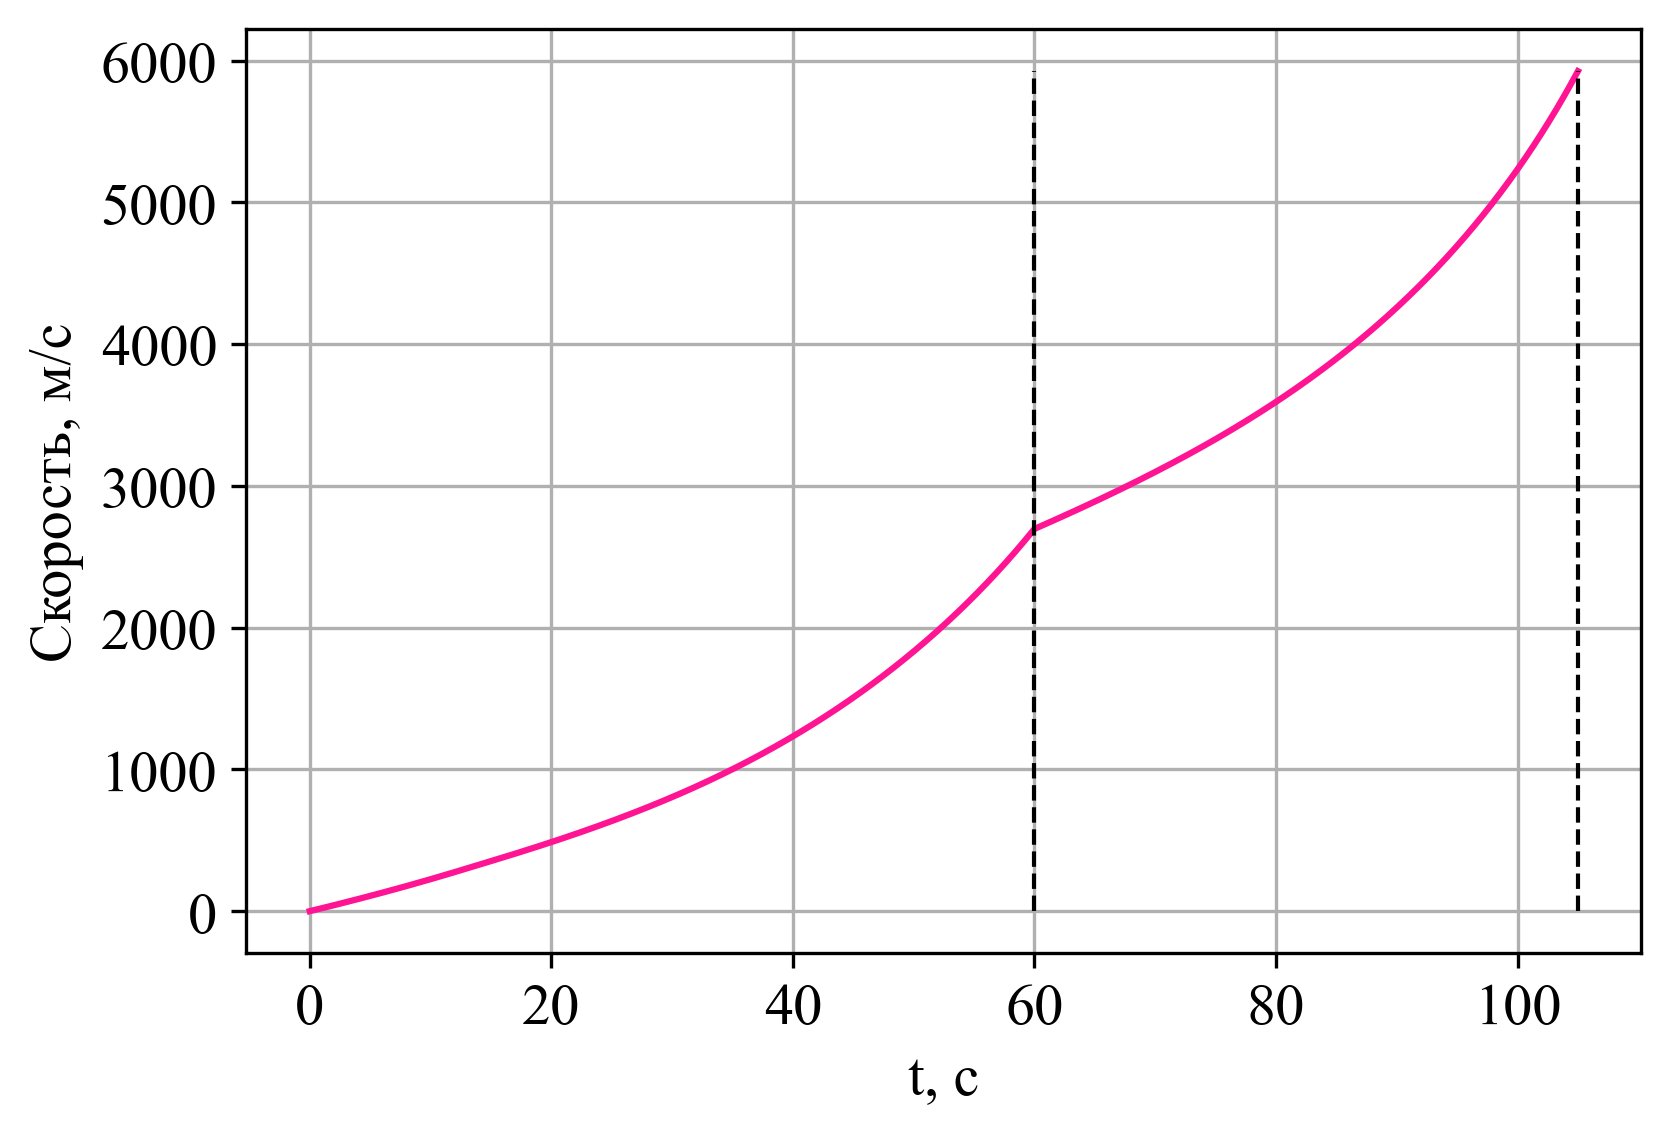

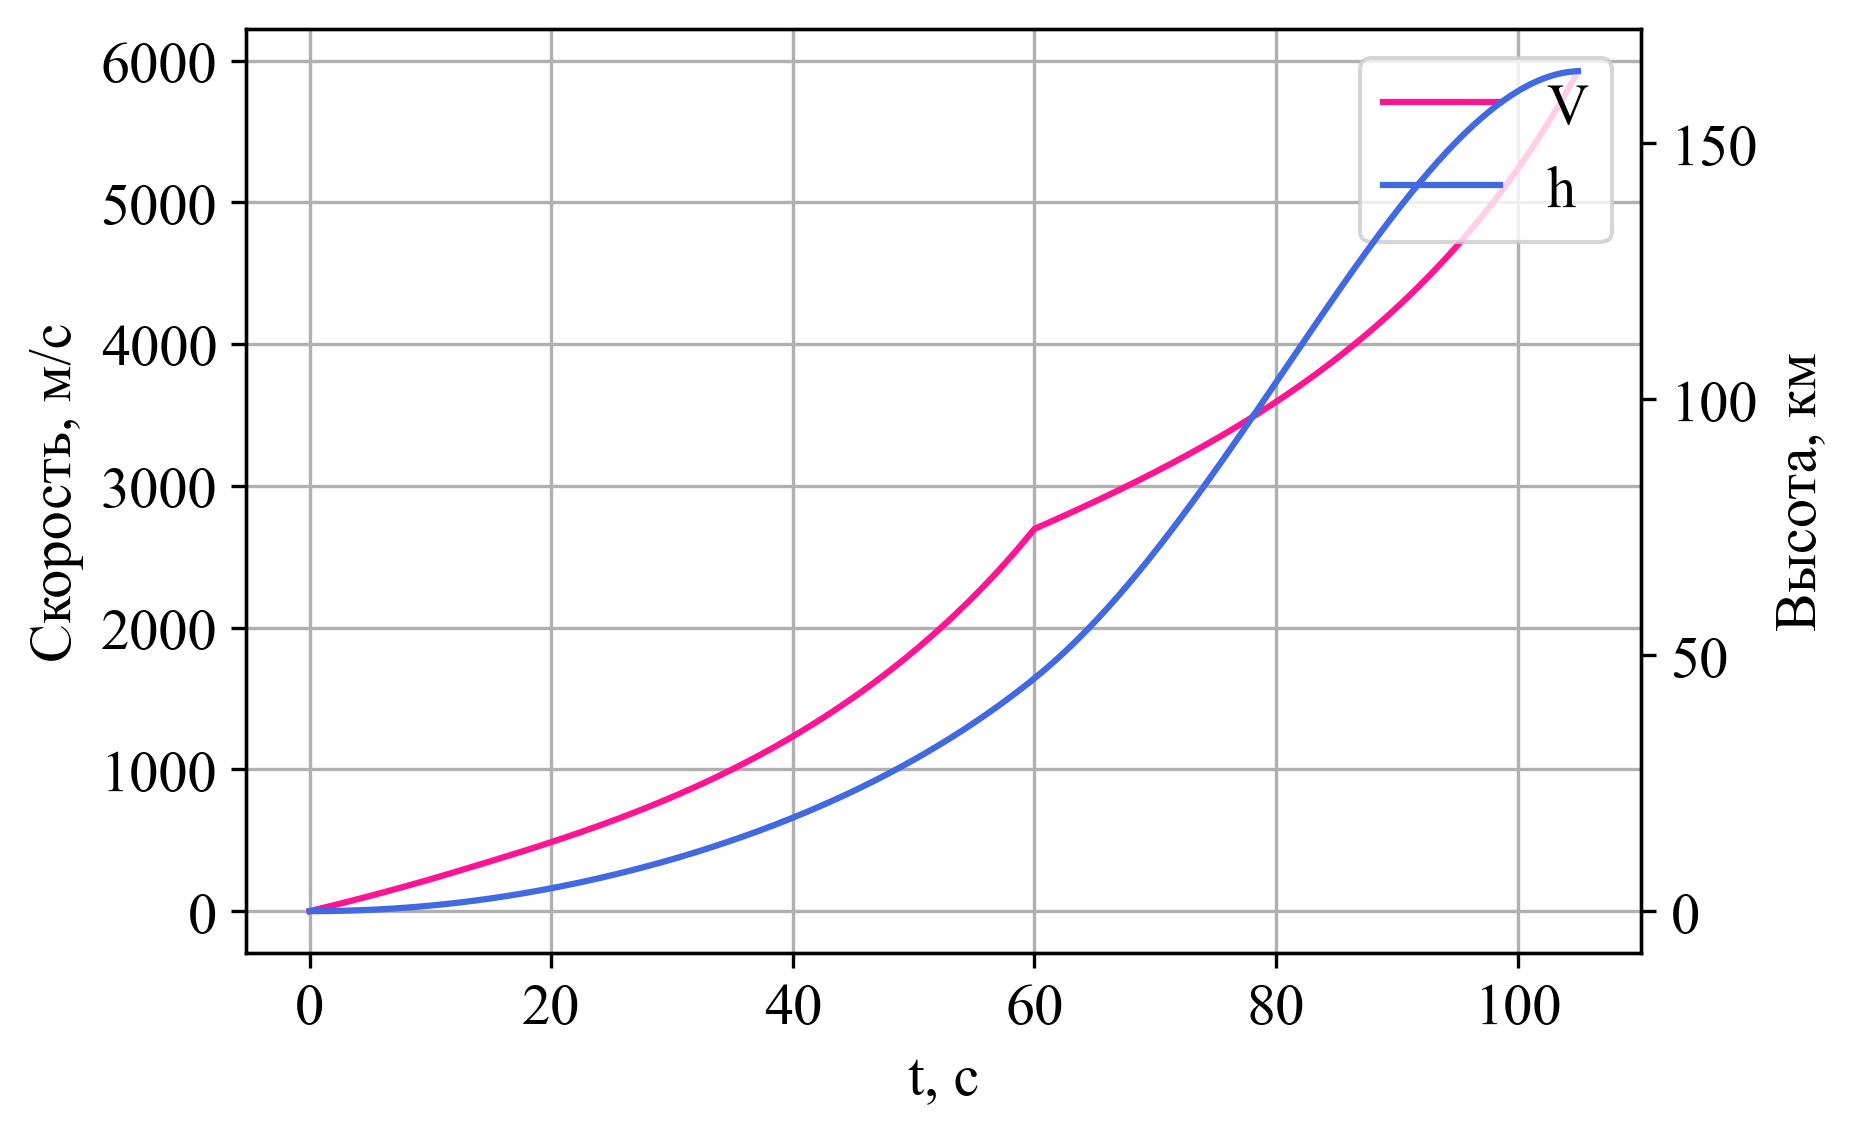

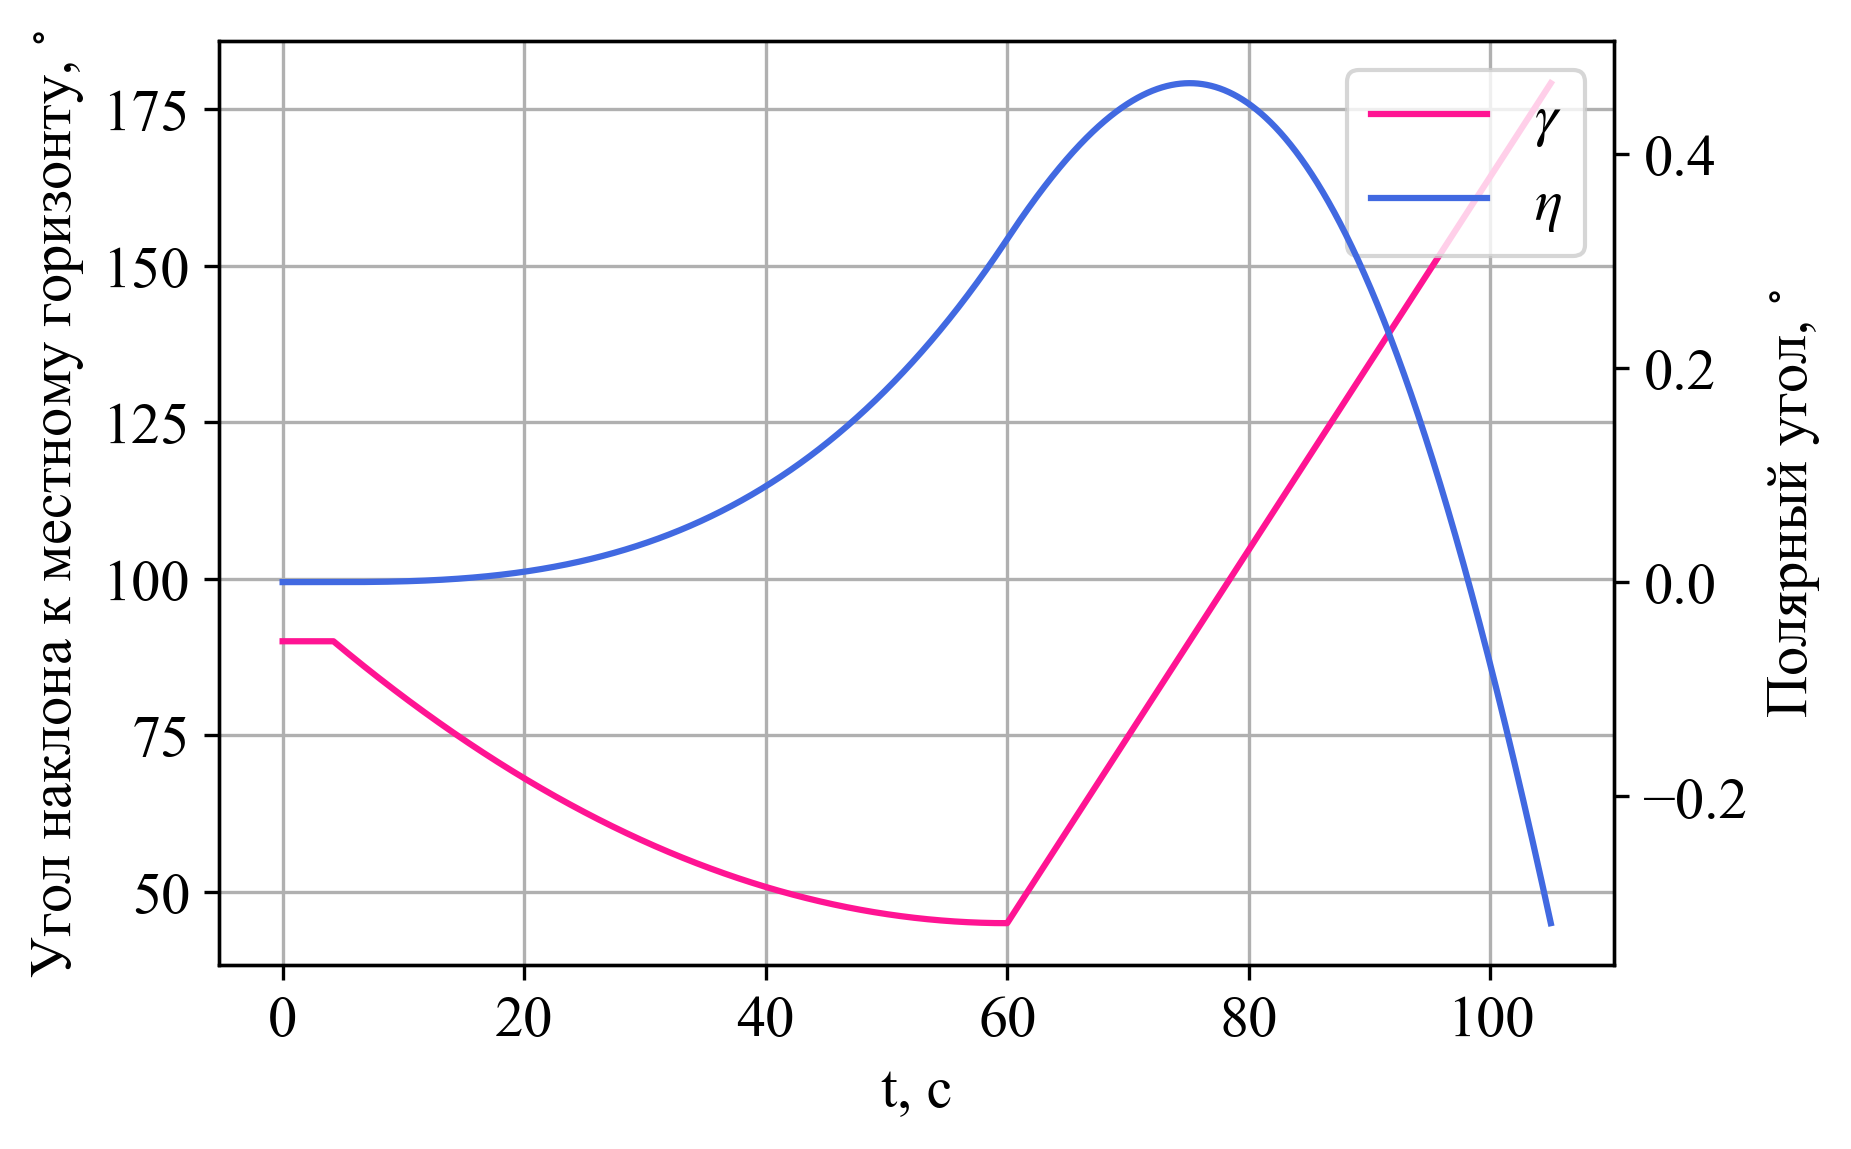

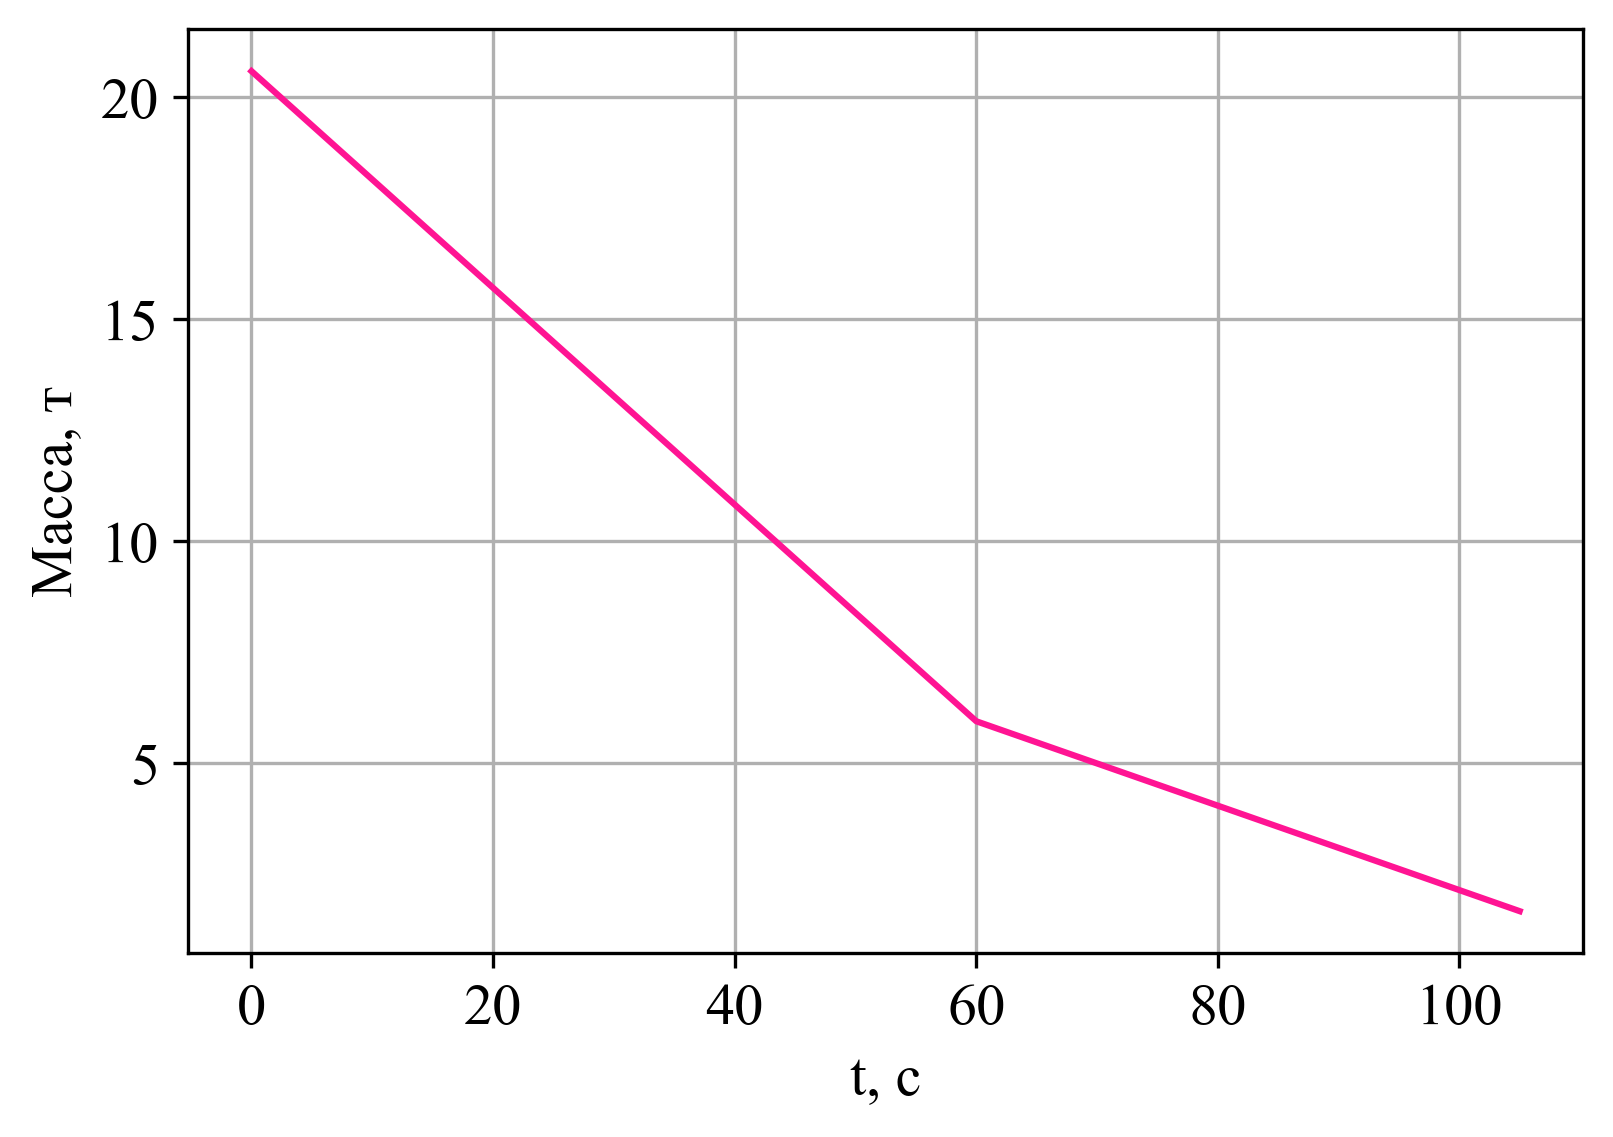

In [38]:
plot_res(sorted_res[0], sorted_res[1], sorted_res[2], sorted_res[3], sorted_res[4], sorted_res[5])
#               t           V               gam              eta            h           m               


In [39]:
eta_integrate = sorted_res[3]
r_integrate = (sorted_res[4]+R_0)*1e-3

r_k = R_0+h_k
nu_k = V_k**2*r_k/g(0)/R_0**2

e_t = (1+(nu_k-2)*nu_k*cos(gam_k)**2)**0.5
p_t = nu_k*r_k*cos(gam_k)**2

def teor_trajectory(eta):
    global p_t, e_t
    return p_t/(1-e_t*np.cos(eta)) 

earth_eta_arr = np.linspace(0, 2*pi, 10000)
earth_R_arr = (np.ones_like(earth_eta_arr)*R_0)*1e-3
r_teor = teor_trajectory(earth_eta_arr)*1e-3
buf1 = abs(r_teor[(earth_eta_arr>pi)*(earth_eta_arr<2*pi)] - r_integrate[-1])
# buf1 = abs(r_teor[:int(len(r_teor)/2)]-earth_R_arr[:int(len(r_teor)/2)])
inds, = np.where( buf1 == min(buf1) )[0]
earth_eta_arr -= earth_eta_arr[(earth_eta_arr>pi)*(earth_eta_arr<2*pi)][inds] - eta_integrate[-1] 
# buf2 = abs(r_teor-r_integrate[-1])
# inds2 = np.where( buf2 == min(buf2) )[0][1]
# earth_eta_arr -= earth_eta_arr[inds2] 

# conda1 = r_teor >= R_0
# conda2 = r_teor <= max(r_integrate)
# conda = conda1 * conda2

# def move_start_point(h, R_0, eta):
#     r_new = (R_0**2 + h**2 - 2*R_0*h*np.cos(eta))**0.5
#     smezh_angle = np.arccos( (h**2 - r_new**2 - R_0**2)/(-2*r_new*R_0) )
#     eta_new = pi - smezh_angle
#     return r_new, eta_new  

# r_integrate_new, eta_integrate_new = move_start_point(r_integrate, R_0*1e-3, eta_integrate)
# r_teor_new, eta_teor_new = move_start_point(r_teor[conda], R_0*1e-3, earth_eta_arr[conda])
# r_earth_new, eta_earth_new = move_start_point(earth_R_arr, R_0*1e-3, earth_eta_arr)

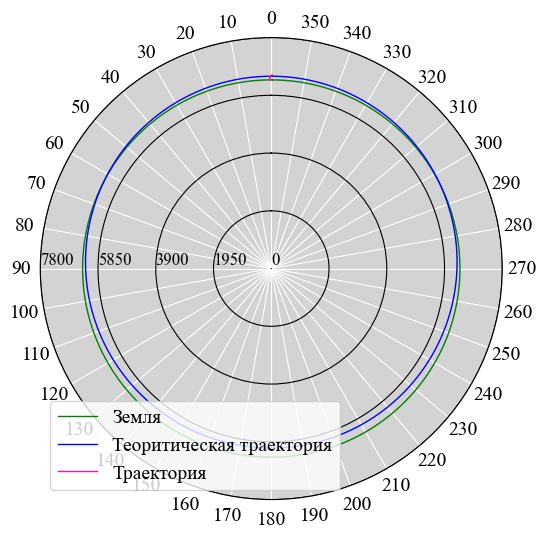

In [40]:
# small_lag = 0.001

# fig = plt.figure(figsize=(12,6))
# ax = fig.add_subplot(111, projection='polar', facecolor='lightgray')

# line1, = ax.plot(eta_integrate_new, r_integrate_new, color='deeppink', linewidth=1, label = u'Траектория')
# # line2, = ax.plot(eta_earth_new, r_earth_new, color='green', linewidth=1, label = u'Земля')
# # line3, = ax.plot(eta_teor_new, r_teor_new, color='b', linewidth=1, linestyle='--', label = u'Теоритическая траектория')

# ax.set_theta_direction(1)

# ax.set_theta_zero_location('N')
# ax.set_rlabel_position(90)

# new_rticks = np.linspace(0.0, max(r_integrate_new), 5) + small_lag
# new_phiticks = np.arange(0., 360., 10.)

# ax.set_thetagrids(new_phiticks, labels=map(int, new_phiticks), fontsize=14, color='k')
# ax.set_rgrids(new_rticks, fontsize=12, fmt='%.0f', color='k')

# ax.grid(True, axis='y', color='k', linestyle='-')
# ax.grid(True, axis='x', color='w', linestyle='-')
# ax.legend(ncol=1, loc=3, frameon=True, fontsize=14)

# plt.savefig('polar_graph_2.png', dpi=300)
# plt.show() 

small_lag = 0.001

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='polar', facecolor='lightgray')

line2, = ax.plot(earth_eta_arr, earth_R_arr, color='green', linewidth=1, label = u'Земля')
line3, = ax.plot(earth_eta_arr, r_teor, color='b', linewidth=1, label = u'Теоритическая траектория')
line1, = ax.plot(eta_integrate, r_integrate, color='deeppink', linewidth=1, label = u'Траектория')

ax.set_theta_direction(1)

ax.set_theta_zero_location('N')
ax.set_rlabel_position(90)

new_rticks = np.linspace(0.0, 7800, 5) + small_lag
new_phiticks = np.arange(0., 360., 10.)

ax.set_thetagrids(new_phiticks, labels=map(int, new_phiticks), fontsize=14, color='k')
ax.set_rgrids(new_rticks, fontsize=12, fmt='%.0f', color='k')

ax.grid(True, axis='y', color='k', linestyle='-')
ax.grid(True, axis='x', color='w', linestyle='-')
ax.legend(ncol=1, loc=3, frameon=True, fontsize=14)

plt.savefig('polar_graph_1.png', dpi=600)
plt.show()

In [41]:
inds = []
for i in range(1, len(t_arr_h)):
    inds.append(np.where(abs(sorted_res[0]-t_arr_h[i]) == min(abs(sorted_res[0]-t_arr_h[i])))[0][0])

dl_arr = (sorted_res[1][1:] + sorted_res[1][:-1])/2*dt
l_arr = np.zeros(len(dl_arr)+1)
for i in range(0, len(dl_arr)):
    l_arr[i+1] = l_arr[i]+dl_arr[i]

In [42]:
df1_to_save_ = {'Dt, с': Dt_arr,
                'h_sr, км': np.array([my_round2(elem*1e-3) for elem in h_sr]),
                'p, МПа': p*1e-6,
                'I_ud, м/с': np.array([my_round2(elem) for elem in I_ud]),
                'I_ud/I_100/1': I_ud/J_100_1,
                'mu': np.array([my_round4(elem) for elem in mu_arr]),
                'alpha': np.array([my_round4(elem) for elem in a_arr])
                }

df2_to_save_ = {'m_0, т': np.array([my_round2(elem*1e-3) for elem in m_arr]),
                'omega, т': np.array([my_round2(elem*1e-3) for elem in om_arr]),
                'G, кг/с': np.array([my_round2(elem) for elem in G_arr]),
                'P, кН': np.array([my_round2(elem*1e-3) for elem in P_arr]),
                'eta_0': np.array([my_round2(elem) for elem in eta_arr]),
                'D, м': np.array([my_round2((elem*4/pi)**0.5) for elem in S_m_arr]),
                }

df3_to_save_ = {'t, c': t_arr_h[1:],
                'V, м/с': np.array([my_round2(elem) for elem in sorted_res[1][inds]]),
                'gama, deg': np.array([my_round2(np.degrees(elem)) for elem in sorted_res[2][inds]]),
                'h, км': np.array([my_round2(elem*1e-3) for elem in sorted_res[4][inds]]),
                'eta, deg': np.array([my_round2(np.degrees(elem)) for elem in sorted_res[3][inds]]),
                'l, км': np.array([my_round2(elem) for elem in 2*pi*earth_R_arr[0]*eta_integrate[inds]]),
                'm, т': np.array([my_round4(elem*1e-3) for elem in sorted_res[5][inds]])
                }

df1_to_save = pd.DataFrame(df1_to_save_)
df2_to_save = pd.DataFrame(df2_to_save_)
df3_to_save = pd.DataFrame(df3_to_save_)

df1_to_save.to_excel('C:/Users/user/Desktop/10 semestr/OTR/Results_DZ/result_tab1.xlsx')
df2_to_save.to_excel('C:/Users/user/Desktop/10 semestr/OTR/Results_DZ/result_tab2.xlsx')
df3_to_save.to_excel('C:/Users/user/Desktop/10 semestr/OTR/Results_DZ/result_tab3.xlsx')

In [47]:
def get_S_m(D):
    return round((0.25*np.pi * D**2), 2)

get_S_m(1.21)

1.15